In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('Microsoft_Stock.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


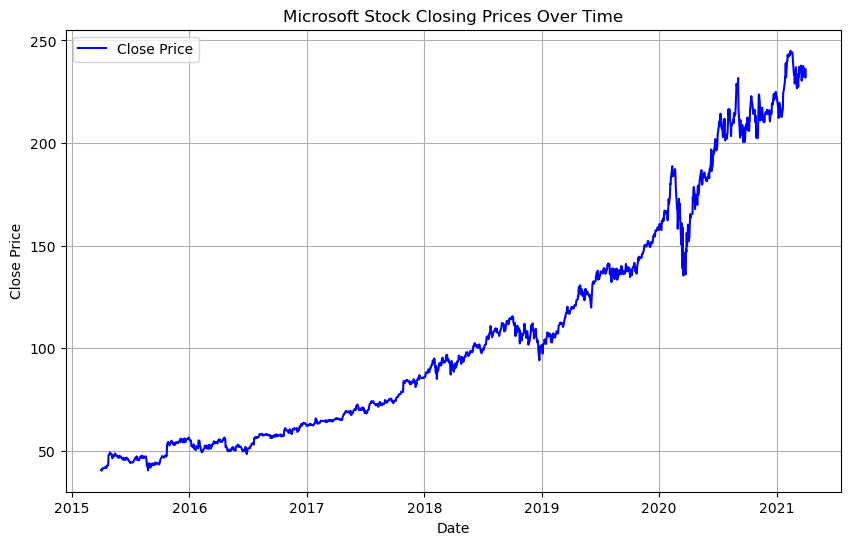

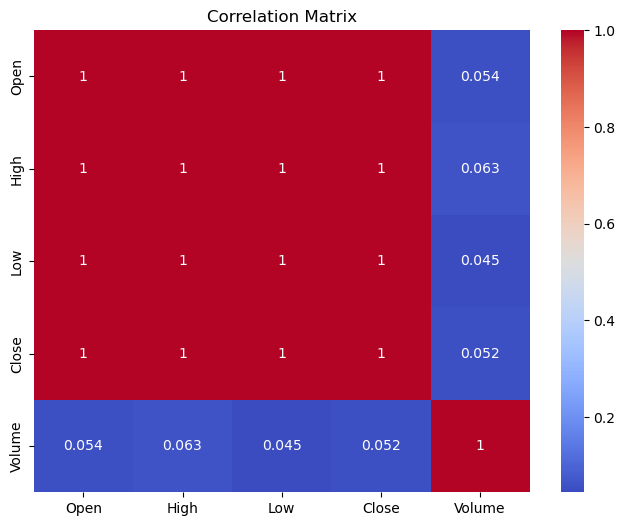

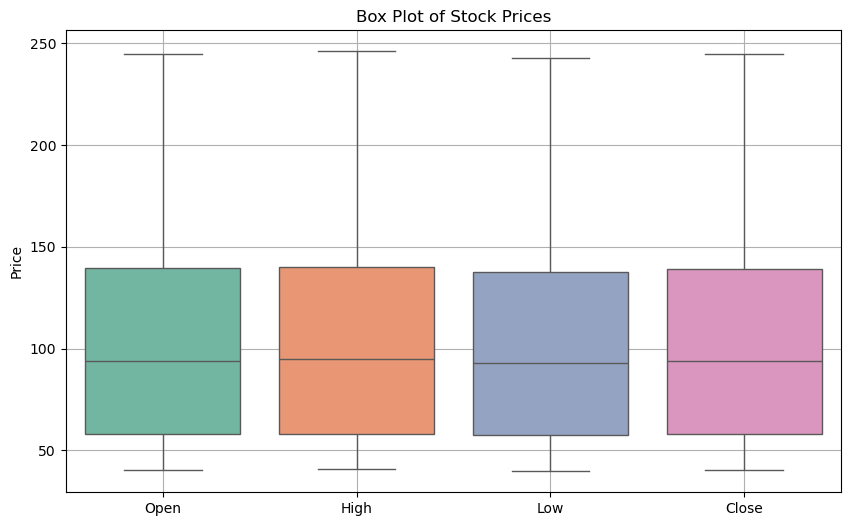

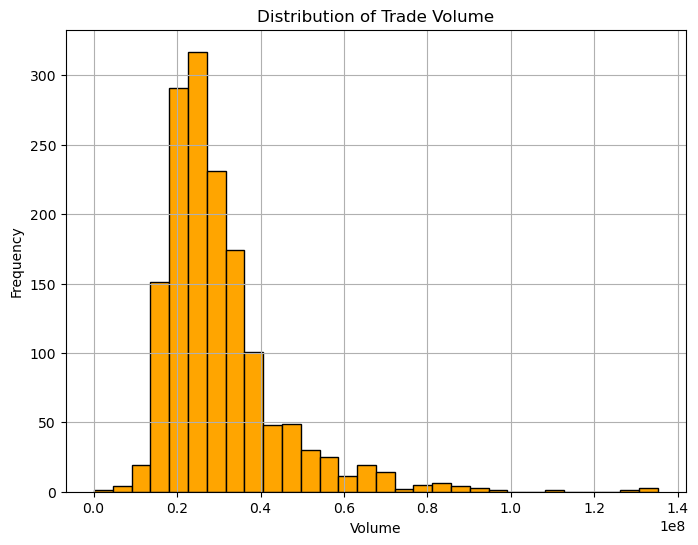

In [12]:
# Load the dataset
df = pd.read_csv('Microsoft_Stock.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df = df.sort_values(by='Date')

# Line plot of closing prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Microsoft Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Box plot for stock prices
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']], palette="Set2")
plt.title('Box Plot of Stock Prices')
plt.ylabel('Price')
plt.grid()
plt.show()

# Histogram for Volume
plt.figure(figsize=(8, 6))
plt.hist(df['Volume'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Trade Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# B. Implement a Model


## LSTM (Long Short-Term Memory):

LSTMs are a type of recurrent neural network (RNN) that are particularly well-suited for time series data due to their ability to capture temporal dependencies and long-term patterns. 
They address the vanishing gradient problem that regular RNNs suffer from, making them effective for modeling sequences like stock price data.

The LSTM layer outputs a sequence of hidden states. The last hidden state is passed to a fully connected layer to generate the final price prediction.

A single LSTM layer with 50 hidden units was chosen to balance model complexity and computational efficiency. This configuration allows the model to capture essential patterns without overfitting to noise in the data.

Epoch [1/50], Train Loss: 0.0029, Val Loss: 0.0469
Epoch [2/50], Train Loss: 0.0007, Val Loss: 0.0024
Epoch [3/50], Train Loss: 0.0001, Val Loss: 0.0013
Epoch [4/50], Train Loss: 0.0000, Val Loss: 0.0007
Epoch [5/50], Train Loss: 0.0000, Val Loss: 0.0004
Epoch [6/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [7/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [8/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [9/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [10/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [11/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [12/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [13/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [14/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [15/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [16/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [17/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [18/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [19/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [20/50], Train 

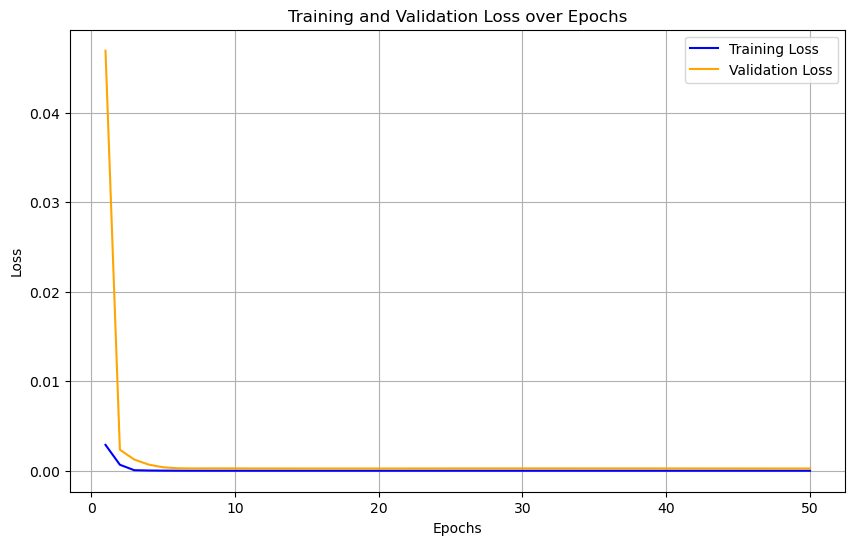

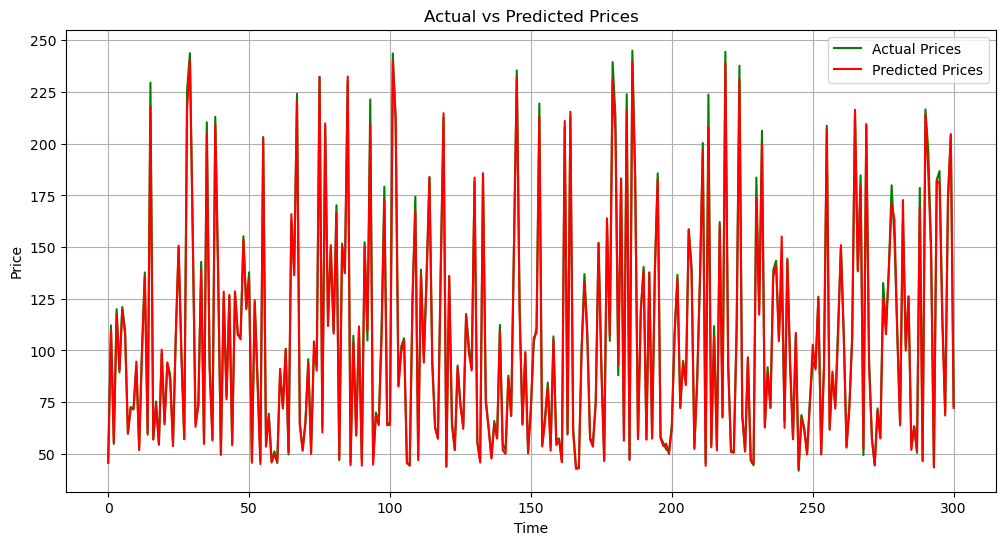

In [13]:
# Load and preprocess data
def preprocess_data(data, sequence_length=7):
    # Normalize features
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape(-1, 1))
    
    # Create sequences
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    
    return np.array(sequences), np.array(labels), scaler

# Define the LSTM model
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last LSTM cell
        return out

# Prepare the data
df = pd.read_csv('Microsoft_Stock.csv')
close_prices = df['Close'].values
sequence_length = 7
X, y, scaler = preprocess_data(close_prices, sequence_length)

# Split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Initialize the model, loss, and optimizer
input_size = 1
hidden_size = 50
num_layers = 1

model = StockPriceLSTM(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
batch_size = 32

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss_epoch = 0
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(x_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss_epoch += loss.item()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val).squeeze()
        val_loss = criterion(val_outputs, y_val.squeeze())

    # Store epoch losses
    train_losses.append(train_loss_epoch / len(X_train))
    val_losses.append(val_loss.item())
    
    # Print epoch progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Plot the losses
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Make predictions on validation set
model.eval()
with torch.no_grad():
    predictions = model(X_val).squeeze().numpy()

# Scale back predictions and actual values
actual_prices = scaler.inverse_transform(y_val.detach().numpy().reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='green')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# C. Two Improvements

## 1. Dropout for Regularization
Dropout is a regularization technique that prevents overfitting by randomly setting a fraction of the input units to 0 during training. Stock price data is prone to overfitting due to its noisy nature, and adding dropout can help improve generalization.

## 2. Bidirectional LSTM
A Bidirectional LSTM processes the sequence in both forward and backward directions, which allows the model to capture patterns more effectively, especially when the relationships in the time series data depend on both past and future contexts.

Epoch [1/50], Train Loss: 0.0036, Val Loss: 0.0520
Epoch [2/50], Train Loss: 0.0008, Val Loss: 0.0029
Epoch [3/50], Train Loss: 0.0001, Val Loss: 0.0016
Epoch [4/50], Train Loss: 0.0001, Val Loss: 0.0012
Epoch [5/50], Train Loss: 0.0001, Val Loss: 0.0007
Epoch [6/50], Train Loss: 0.0001, Val Loss: 0.0005
Epoch [7/50], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [8/50], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [9/50], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [10/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [11/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [12/50], Train Loss: 0.0000, Val Loss: 0.0005
Epoch [13/50], Train Loss: 0.0000, Val Loss: 0.0004
Epoch [14/50], Train Loss: 0.0000, Val Loss: 0.0004
Epoch [15/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [16/50], Train Loss: 0.0000, Val Loss: 0.0002
Epoch [17/50], Train Loss: 0.0000, Val Loss: 0.0004
Epoch [18/50], Train Loss: 0.0000, Val Loss: 0.0003
Epoch [19/50], Train Loss: 0.0000, Val Loss: 0.0002
Epoch [20/50], Train 

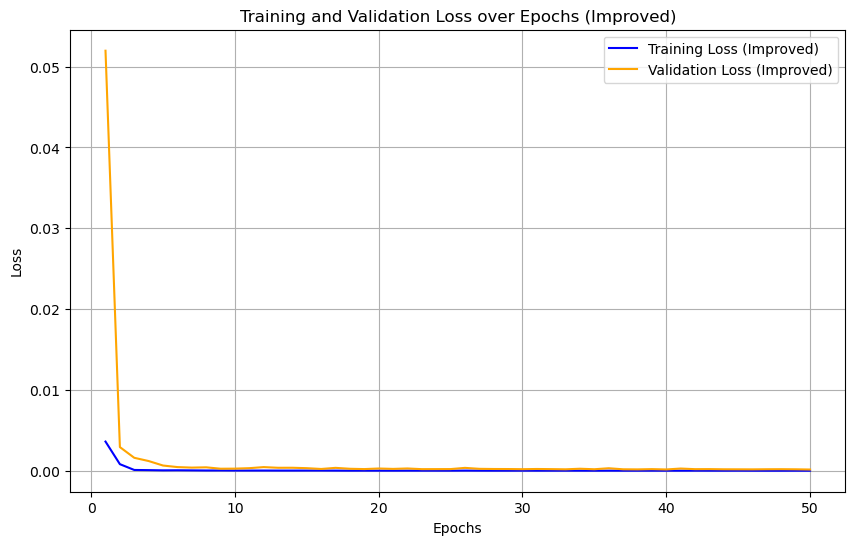

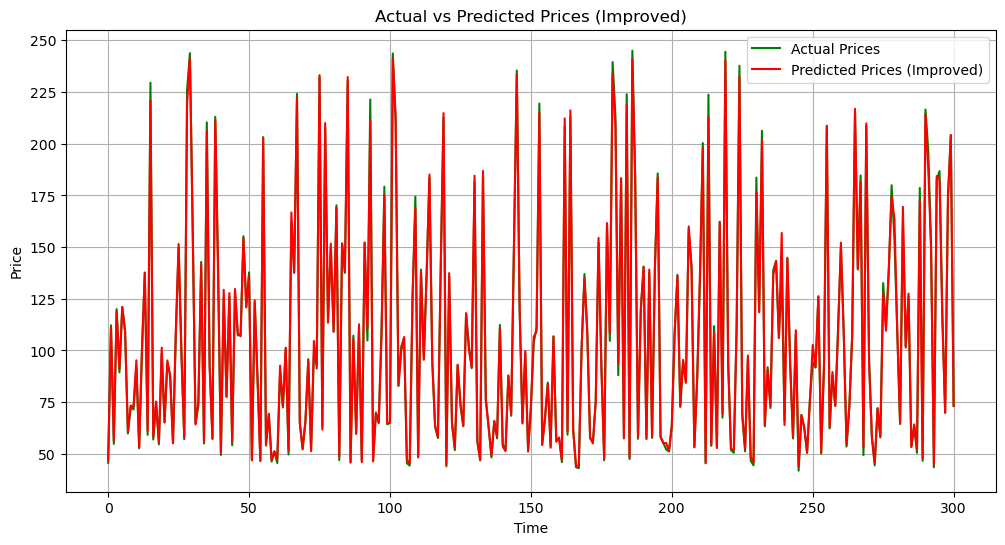

In [14]:
# Updated LSTM model with improvements
class StockPriceLSTMImproved(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, dropout_rate=0.2):
        super(StockPriceLSTMImproved, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True)  # Bidirectional LSTM
        self.dropout = nn.Dropout(dropout_rate)  
        self.fc = nn.Linear(hidden_size * 2, 1)  
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)  
        out = self.fc(out[:, -1, :])  # Take the output of the last LSTM cell
        return out

# Reinitialize the model with improvements
hidden_size = 50
dropout_rate = 0.2
model_improved = StockPriceLSTMImproved(input_size, hidden_size, num_layers, dropout_rate)

# Use the same criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.001)

# Training the improved model
train_losses_improved = []
val_losses_improved = []

for epoch in range(num_epochs):
    model_improved.train()
    train_loss_epoch = 0
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model_improved(x_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_epoch += loss.item()
    
    # Validation phase
    model_improved.eval()
    with torch.no_grad():
        val_outputs = model_improved(X_val).squeeze()
        val_loss = criterion(val_outputs, y_val.squeeze())

    # Store epoch losses
    train_losses_improved.append(train_loss_epoch / len(X_train))
    val_losses_improved.append(val_loss.item())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_improved[-1]:.4f}, Val Loss: {val_losses_improved[-1]:.4f}')

# Plot the losses for improved model
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_improved, label='Training Loss (Improved)', color='blue')
plt.plot(epochs, val_losses_improved, label='Validation Loss (Improved)', color='orange')
plt.title('Training and Validation Loss over Epochs (Improved)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Make predictions on validation set
model_improved.eval()
with torch.no_grad():
    predictions_improved = model_improved(X_val).squeeze().numpy()

# Scale back predictions and actual values
predicted_prices_improved = scaler.inverse_transform(predictions_improved.reshape(-1, 1))

# Plot actual vs predicted prices for improved model
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='green')
plt.plot(predicted_prices_improved, label='Predicted Prices (Improved)', color='red')
plt.title('Actual vs Predicted Prices (Improved)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


# D. Optimize hyperparameters

In [15]:
from itertools import product

# Define hyperparameter grid
hidden_sizes = [32, 50, 64]
dropout_rates = [0.1, 0.2, 0.3]
learning_rates = [0.001, 0.005]
batch_sizes = [16, 32]

results = []

# Grid search over hyperparameters
for hidden_size, dropout_rate, learning_rate, batch_size in product(hidden_sizes, dropout_rates, learning_rates, batch_sizes):
    print(f"Testing configuration: Hidden Size={hidden_size}, Dropout Rate={dropout_rate}, LR={learning_rate}, Batch Size={batch_size}")
    
    model_tuned = StockPriceLSTMImproved(input_size, hidden_size, num_layers, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_tuned.parameters(), lr=learning_rate)
    
    # Training the model with the current configuration
    train_losses_tuned = []
    val_losses_tuned = []
    for epoch in range(num_epochs):
        model_tuned.train()
        train_loss_epoch = 0
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            outputs = model_tuned(x_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_epoch += loss.item()
        
        # Validation phase
        model_tuned.eval()
        with torch.no_grad():
            val_outputs = model_tuned(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val.squeeze())
        
        # Store epoch losses
        train_losses_tuned.append(train_loss_epoch / len(X_train))
        val_losses_tuned.append(val_loss.item())
    
    # Log the results for the current configuration
    avg_val_loss = np.mean(val_losses_tuned)
    results.append({
        'hidden_size': hidden_size,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss': avg_val_loss
    })
    print(f"Validation Loss for current configuration: {avg_val_loss:.4f}")

# Find the best configuration
best_config = min(results, key=lambda x: x['val_loss'])
print("\nBest Configuration:")
print(best_config)


Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.001, Batch Size=16
Validation Loss for current configuration: 0.0006
Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.001, Batch Size=32
Validation Loss for current configuration: 0.0014
Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.005, Batch Size=16
Validation Loss for current configuration: 0.0002
Testing configuration: Hidden Size=32, Dropout Rate=0.1, LR=0.005, Batch Size=32
Validation Loss for current configuration: 0.0002
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.001, Batch Size=16
Validation Loss for current configuration: 0.0006
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.001, Batch Size=32
Validation Loss for current configuration: 0.0020
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.005, Batch Size=16
Validation Loss for current configuration: 0.0003
Testing configuration: Hidden Size=32, Dropout Rate=0.2, LR=0.005, Batch Size=32
Va

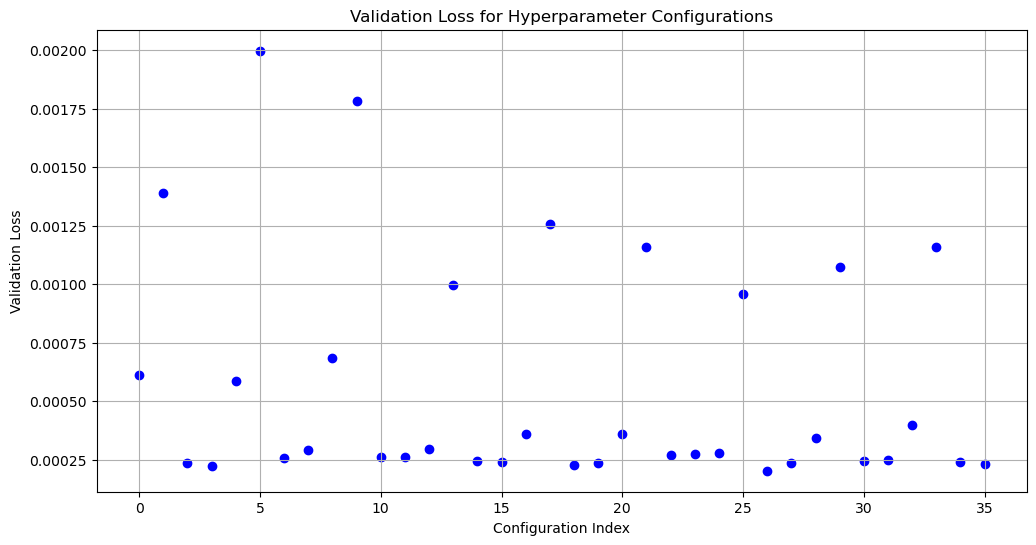

In [16]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
plt.scatter(range(len(results)), results_df['val_loss'], c='blue')
plt.title('Validation Loss for Hyperparameter Configurations')
plt.xlabel('Configuration Index')
plt.ylabel('Validation Loss')
plt.grid()
plt.show()

# Retrain with the best configuration
best_model = StockPriceLSTMImproved(input_size, best_config['hidden_size'], num_layers, best_config['dropout_rate'])
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_config['learning_rate'])
batch_size = best_config['batch_size']

# E. Results Comparison and Discussion

## Baseline Model Results:
Training Loss and Validation Loss Progression:

Epoch 1:
Train Loss: 0.0029
Validation Loss: 0.0469

Epoch 50:
Train Loss: 0.0000
Validation Loss: 0.0003

Key Observations:
The training loss decreases rapidly, reaching near-zero by the second epoch.
Validation loss decreases steadily, stabilizing around 0.0003 by epoch 50, which indicates the model is converging well, but there is a chance that the model may overfit to the training data as the validation loss stabilizes.

## Enhanced Model Results
Training Loss and Validation Loss Progression:

Epoch 1:
Train Loss: 0.0036
Validation Loss: 0.0520

Epoch 50:
Train Loss: 0.0000
Validation Loss: 0.0002

Key Observations:
The initial validation loss (0.0520) is higher than the baseline model's 0.0469. This is expected, as the model architecture is more complex and requires more time to converge.
The train loss decreases at a steady rate, reaching near-zero around epoch 6, indicating the model is still learning effectively.
Validation loss drops and stabilizes at 0.0002 by epoch 50, which is better than the baseline model's 0.0003. This indicates that the model with improvements has generalized better.

Impact of Bidirectional LSTM:
The introduction of Bidirectional LSTM allowed the model to better capture both past and future dependencies, which is important in sequence prediction tasks like stock price forecasting. It also improved the model's ability to understand the context from both directions, which might explain the better performance seen in validation loss.

Impact of Dropout Regularization:
Dropout was added to regularize the model and reduce overfitting. This is reflected in the validation loss being more stable and lower (0.0002) compared to the baseline (0.0003). Without dropout, the model could have overfitted the training data and shown poor generalization on the validation set.


## Hyperparameter Configuration and Performance
Best Hyperparameters After Tuning:

Hidden Size: 64

Dropout Rate: 0.1

Learning Rate: 0.005

Batch Size: 16

Validation Loss: 0.0002

The hidden size of 64 and a learning rate of 0.005 provided a good balance between model capacity and training speed. The dropout rate of 0.1 helped in reducing overfitting, resulting in better generalization as reflected by the lower validation loss.